In [1]:
import os
import sys
import glob
import imageio
import numpy as np
import scipy.io as sio
import matplotlib.cm as cm
from math import log10, floor
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy.stats import moment, kurtosis

In [2]:
def make_directory(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)  

In [3]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

In [4]:
class resonance_lines(object):
	
	def __init__(self, Qx_range, Qy_range, orders, periodicity):
		
		if np.std(Qx_range):
			self.Qx_min = np.min(Qx_range)
			self.Qx_max = np.max(Qx_range)
		else:
			self.Qx_min = np.floor(Qx_range)-0.05
			self.Qx_max = np.floor(Qx_range)+1.05
		if np.std(Qy_range):
			self.Qy_min = np.min(Qy_range)
			self.Qy_max = np.max(Qy_range)
		else:
			self.Qy_min = np.floor(Qy_range)-0.05
			self.Qy_max = np.floor(Qy_range)+1.05

		self.periodicity = periodicity
									
		nx, ny = [], []

		for order in np.nditer(np.array(orders)):
			t = np.array(range(-order, order+1))
			nx.extend(order - np.abs(t))
			ny.extend(t)
		nx = np.array(nx)
		ny = np.array(ny)
	
		cextr = np.array([nx*np.floor(self.Qx_min)+ny*np.floor(self.Qy_min), \
						  nx*np.ceil(self.Qx_max)+ny*np.floor(self.Qy_min), \
						  nx*np.floor(self.Qx_min)+ny*np.ceil(self.Qy_max), \
						  nx*np.ceil(self.Qx_max)+ny*np.ceil(self.Qy_max)], dtype='int')
		cmin = np.min(cextr, axis=0)
		cmax = np.max(cextr, axis=0)
		res_sum = [range(cmin[i], cmax[i]+1) for i in xrange(cextr.shape[1])]								
		self.resonance_list = zip(nx, ny, res_sum)
		
	def plot_resonance(self, figure_object = None):	
		plt.ion()
		if figure_object:
			fig = figure_object
			plt.figure(fig.number)
		else:
			fig = plt.figure()
		Qx_min = self.Qx_min
		Qx_max = self.Qx_max
		Qy_min = self.Qy_min
		Qy_max = self.Qy_max 
		plt.xlim(Qx_min, Qx_max)
		plt.ylim(Qy_min, Qy_max)
		plt.xlabel('Qx')
		plt.ylabel('Qy')
		for resonance in self.resonance_list:
			nx = resonance[0]
			ny = resonance[1]
			for res_sum in resonance[2]:
				if ny:
					line, = plt.plot([Qx_min, Qx_max], \
					    [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny])
				else:
					line, = plt.plot([np.float(res_sum)/nx, np.float(res_sum)/nx],[Qy_min, Qy_max])
				if ny%2:
					plt.setp(line, linestyle='--') # for skew resonances
				if res_sum%self.periodicity:
					plt.setp(line, color='b')	# non-systematic resonances
				else:
					plt.setp(line, color='r', linewidth=2.0) # systematic resonances
		plt.draw()
		return fig
		
	def print_resonances(self):
		for resonance in self.resonance_list:
			for res_sum in resonance[2]:
				'''
				print str(resonance[0]).rjust(3), 'Qx ', ("+", "-")[resonance[1]<0], \
					  str(abs(resonance[1])).rjust(2), 'Qy = ', str(res_sum).rjust(3), \
					  '\t', ("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0]
				'''
				print '%s %s%s = %s\t%s'%(str(resonance[0]).rjust(2), ("+", "-")[resonance[1]<0], \
						str(abs(resonance[1])).rjust(2), str(res_sum).rjust(4), \
						("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0])


In [5]:
def add_input_file(dd, filename, label):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [6]:
def gaussian(x, A, mu, sig):
    """gaussian_3_parameter(x, A, mu, sig)"""
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [7]:
plt.close('all')

In [8]:
source_dir =  '../03_SbS_Tomo_Lattice_V_10/bunch_output/'
folder = './03_SbS_Tomo_Lattice_V_10' #output directory
make_directory(folder)

files = glob.glob(source_dir + '*.mat')
sorted(files)

Creation of the directory ./03_SbS_Tomo_Lattice_V_10 failed


['../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_-000001.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000001.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000002.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000003.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000004.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000005.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000006.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000007.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000008.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000009.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000010.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000011.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000012.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000013.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000014.mat',
 '../03_S

In [9]:
files = sorted(files)[1:]

In [10]:
files

['../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000001.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000002.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000003.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000004.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000005.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000006.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000007.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000008.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000009.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000010.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000011.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000012.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000013.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000014.mat',
 '../03_SbS_Tomo_Lattice_V_10/bunch_output/mainbunch_000015.mat',
 '../03_Sb

In [11]:
main_label = ''
sc = 'SbS'
legend_label = 'Turn'
case = ''

# Tune Footprint with x and y histograms

In [ ]:
histogram_plots = False

if histogram_plots:
    master_bins = 512
    max_1d_hist = 20

    min_tune = 5.80
    max_tune = 6.25
    q_fine = np.arange(5.5, 6.51, 0.01)


    first_turn = False

    for file in sorted(files, reverse=False):
        tune_tit = '(6.21, 6.245)'

        try: 
            #./Output_Files/Run2_BCMS_Turn_1.mat
            turn = int(file.split('/')[-1].split('_')[1].split('.')[0])
            case = str(file.split('/')[1].split('_')[4] + '_' + file.split('/')[1].split('_')[5])
            #turn = '%04d'%turn
        except:
            turn = ''

        print '\n\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'

        # Load data 
        #------------------------------------------------------------------------------
        particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
        #x  = particles.x
        #xp = particles.xp
        #y  = particles.y
        #yp = particles.yp
        #z  = particles.z
        #dE = particles.dE
        qx = particles.ParticlePhaseAttributes[2,:]
        qy = particles.ParticlePhaseAttributes[3,:]
        qx[np.where(qx>0.5)] -= 1
        qy[np.where((qy>0.6) & (qx<0.25))] -= 1 

        my_cmap = plt.cm.jet
        my_cmap.set_under('w',1)

        title = str( case + ' ' + tune_tit + ' Turn = ' + str(turn) )    

        fig = plt.figure(figsize=(7,7))
        gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
        r = resonance_lines((min_tune, max_tune),(min_tune, max_tune),(1,2,3,4),10)

        # Calculate RMS Qx and Qy
        #------------------------------------------------------------------------------
        Q_x_rms = np.sqrt(moment(6+qx,2))
        Q_y_rms = np.sqrt(moment(6+qy,2))
        Q_x_min = np.min(6+qx)
        Q_x_max = np.max(6+qx)
        Q_y_min = np.min(6+qy)
        Q_y_max = np.max(6+qy)
        Delta_q_x = Q_x_max - Q_x_min
        Delta_q_y = Q_y_max - Q_y_min    
        Delta_q_x_4sig = 4 * Q_x_rms
        Delta_q_y_4sig = 4 * Q_y_rms
        Delta_q_x_6sig = 6 * Q_x_rms
        Delta_q_y_6sig = 6 * Q_y_rms

        # TEXT BOX (top right)
        #------------------------------------------------------------------------------
        #ax4 = fig.add_subplot(gs[0, 2:3])
        ax4txt = str(
                    #'q_x_min = ' + str(round_sig(Q_x_min)) + '\n' +
                    #'q_x_max = ' + str(round_sig(Q_x_max)) + '\n' +
                    #'q_y_min = ' + str(round_sig(Q_y_min)) + '\n' +
                    #' Turn = ' + str(turn) + '\n' +
                    '<q_x> = ' + str(round_sig(np.mean(6+qx),3)) + '\n' +
                    '<q_y> = ' + str(round_sig(np.mean(6+qy),3)) + '\n' + '\n' +
                    'q_x_RMS = ' + str(round_sig(Q_x_rms)) + '\n' +
                    'q_y_RMS = ' +str(round_sig(Q_y_rms)) + '\n'  + '\n' +  
                    'Dq_x (4*RMS) = ' + str(round_sig(Delta_q_x_4sig)) + '\n' +
                    'Dq_y (4*RMS) = ' + str(round_sig(Delta_q_y_4sig)) + '\n' + '\n' +
                    'Dq_x (6*RMS) = ' + str(round_sig(Delta_q_x_6sig)) + '\n' +
                    'Dq_y (6*RMS) = ' + str(round_sig(Delta_q_y_6sig)) + '\n'
                    )
        #ax4.text(0.001, 0.001, ax4txt, fontsize=10)
        #ax4.set_yticklabels([])
        #ax4.set_xticklabels([])

        # FIRST SUBPLOT - x histogram
        #------------------------------------------------------------------------------
        ax1 = fig.add_subplot(gs[0, 0:2])
        ax1.set_title(title)    
        n_x, bins_x, patches_x = ax1.hist(6+qx, bins=master_bins, range=(r.Qx_min, r.Qx_max), density=True) #, norm=mcolors.PowerNorm(gamma))
        bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins

        if first_turn:
            if np.max(n_x) > max_1d_hist :
                max_1d_hist = round(np.max(n_x),2) + 2
                print '\n\t max_1d_hist set to ', max_1d_hist
                first_turn = False

        # fit Gaussian to histogram
        try:    
            amp_min_x = 0.99 * np.max(n_x)
            amp_max_x = 1.2 * np.max(n_x)
            mean_min_x = 0.9 * bins_x[np.argmax(n_x)]
            mean_max_x = 1.1 * bins_x[np.argmax(n_x)]
            sig_min_x = 0.5 * Q_x_rms
            sig_max_x = 1.5 * Q_x_rms
            popt, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
            #ax1.plot(q_fine, gaussian(q_fine, popt[0], popt[1], popt[2]), 'k--', lw=1, label='Gaussian Fit')
            #ax1.plot(q_fine, gaussian(q_fine, popt[0], popt[1], Q_x_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
            #ax1.legend(loc=2)
        except RuntimeError:
            print '\n\t RuntimeError ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' q_x Gaussian fit not found'

        # ~ ax1.set_ylabel('Frequency')
        ax1.set_ylabel('Density [arb.]')
        ax1.grid(which='both', ls=':', lw=0.5)
        ax1.set_ylim(0, max_1d_hist)
        ax1.set_xlim(min_tune, max_tune)
        ax1.set_xticklabels([])

        # SECOND SUBPLOT - y histogram
        #------------------------------------------------------------------------------
        ax3 = fig.add_subplot(gs[1:3, 2])
        n_y, bins_y, patches_y = ax3.hist(6+qy, bins=master_bins, range=(r.Qy_min, r.Qy_max), orientation=u'horizontal', density=True) #, norm=mcolors.PowerNorm(gamma))
        bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

        # fit Gaussian to histogram
        try:
            amp_min_y = 0.99 * np.max(n_y)
            amp_max_y = 1.2 * np.max(n_y)
            mean_min_y = 0.9 * bins_y[np.argmax(n_y)]
            mean_max_y = 1.1 * bins_y[np.argmax(n_y)]
            sig_min_y = 0.5 * Q_y_rms
            sig_max_y = 1.5 * Q_y_rms
            popt, pcov = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
            #ax3.plot(gaussian(q_fine, popt[0], popt[1], popt[2]), q_fine, 'k--', lw=1, label='Gaussian Fit')
            #ax3.plot(gaussian(q_fine, popt[0], popt[1], Q_y_rms), q_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
        except RuntimeError:
            print '\n\t RuntimeError ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' q_y Gaussian fit not found'

        # ~ ax3.set_xlabel('Frequency')    
        ax3.set_xlabel('Density [arb.]')    
        ax3.set_xlim(0, max_1d_hist)
        ax3.set_ylim(min_tune, max_tune)
        ax3.grid(which='both', ls=':', lw=0.5)
        ax3.set_yticklabels([])

        # MAIN PLOT: TUNE FOOTPRINT
        #------------------------------------------------------------------------------
        ax2 = fig.add_subplot(gs[1:3, 0:2])
        r.plot_resonance(fig)
        ax2.hist2d(6+qx, 6+qy, bins=master_bins, cmap=my_cmap, vmin=1, range=[[r.Qx_min, r.Qx_max], [r.Qy_min, r.Qy_max]]) #, norm=mcolors.PowerNorm(gamma))
        ax2.set_xlabel(r'Q$_x$')
        ax2.set_ylabel(r'Q$_y$')
        ax2.set_ylim(min_tune, max_tune)
        ax2.grid(which='both', ls=':', lw=0.5)

        plt.tight_layout()
        savename = str(folder + '/Tune_Footprint_' + case + '_turn_' + str(turn) + '_new.png' )
        #tune_gifs.append(savename)
        fig.savefig(savename, dpi=500)
        plt.close(fig)

# Plot tune footprint with no histograms

In [19]:
master_bins = 512
max_1d_hist = 20

min_tune = 5.80
max_tune = 6.25
q_fine = np.arange(5.5, 6.51, 0.01)


first_turn = False

for file in sorted(files, reverse=False):
    
    tune_tit = '(6.21, 6.245)'    
    try: 
        #./Output_Files/Run2_BCMS_Turn_1.mat
        turn = int(file.split('/')[-1].split('_')[1].split('.')[0])
        case = str(file.split('/')[1].split('_')[4] + '_' + file.split('/')[1].split('_')[5])
        if str(file.split('/')[1].split('_')[4]) is 'V':
            tune_tit = '(6.21, 6.' + str(file.split('/')[1].split('_')[5]) + ')'
        else:
            tune_tit = '(6.' + str(file.split('/')[1].split('_')[5]) + '6.24)'
            
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\n\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', turn
    
    # Load data 
    #------------------------------------------------------------------------------
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    #x  = particles.x
    #xp = particles.xp
    #y  = particles.y
    #yp = particles.yp
    #z  = particles.z
    #dE = particles.dE
    qx = particles.ParticlePhaseAttributes[2,:]
    qy = particles.ParticlePhaseAttributes[3,:]
    qx[np.where(qx>0.5)] -= 1
    qy[np.where((qy>0.6) & (qx<0.25))] -= 1 
     
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( 'Working Point = ' + tune_tit + ', Turn = ' + str(turn) )    
    
    plt.rcParams['figure.figsize'] = [6.0, 6.0]
    fig1, ax1 = plt.subplots(constrained_layout=True)
    ax1.set_title(title) 
    #gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
    r = resonance_lines((min_tune, max_tune),(min_tune, max_tune),(1,2,3,4),10)
 
    # Calculate RMS Qx and Qy
    #------------------------------------------------------------------------------
    Q_x_rms = np.sqrt(moment(6+qx,2))
    Q_y_rms = np.sqrt(moment(6+qy,2))
    Q_x_min = np.min(6+qx)
    Q_x_max = np.max(6+qx)
    Q_y_min = np.min(6+qy)
    Q_y_max = np.max(6+qy)
    Delta_q_x = Q_x_max - Q_x_min
    Delta_q_y = Q_y_max - Q_y_min    
    Delta_q_x_4sig = 4 * Q_x_rms
    Delta_q_y_4sig = 4 * Q_y_rms
    Delta_q_x_6sig = 6 * Q_x_rms
    Delta_q_y_6sig = 6 * Q_y_rms

    
    # MAIN PLOT: TUNE FOOTPRINT
    #------------------------------------------------------------------------------
    #ax1 = fig.add_subplot(gs[1:3, 0:2])
    r.plot_resonance(fig1)
    ax1.hist2d(6+qx, 6+qy, bins=master_bins, cmap=my_cmap, vmin=1, range=[[r.Qx_min, r.Qx_max], [r.Qy_min, r.Qy_max]]) #, norm=mcolors.PowerNorm(gamma))
    ax1.set_xlabel(r'Q$_x$')
    ax1.set_ylabel(r'Q$_y$')
    ax1.set_ylim(min_tune, max_tune)
    ax1.grid(which='both', ls=':', lw=0.5)
 
    plt.tight_layout()
    savename = str(folder + '/Tune_Footprint_' + case + '_turn_' + str(turn) + '_simple.png' )
    #tune_gifs.append(savename)
    fig1.savefig(savename, dpi=500)
    plt.close(fig1)


	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  1

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  2

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  3

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  4

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  5

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  6

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  7

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  8

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  9

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  10

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  11

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  12

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  13

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  14

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  15

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  16

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  17

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  18



# Plot Vertical Phase Space

In [33]:
master_bins = 512
max_1d_hist = 20

min_tune = 5.80
max_tune = 6.25
q_fine = np.arange(5.5, 6.51, 0.01)


first_turn = True

for file in sorted(files, reverse=True):
    
    tune_tit = '(6.21, 6.245)'    
    try: 
        #./Output_Files/Run2_BCMS_Turn_1.mat
        turn = int(file.split('/')[-1].split('_')[1].split('.')[0])
        case = str(file.split('/')[1].split('_')[4] + '_' + file.split('/')[1].split('_')[5])
        if str(file.split('/')[1].split('_')[4]) is 'V':
            tune_tit = '(6.21, 6.' + str(file.split('/')[1].split('_')[5]) + ')'
        else:
            tune_tit = '(6.' + str(file.split('/')[1].split('_')[5]) + '6.24)'
            
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\n\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', turn
    
    # Load data 
    #------------------------------------------------------------------------------
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    #x  = particles.x
    #xp = particles.xp
    y  = particles.y *1E3
    yp = particles.yp *1E3
    #z  = particles.z
    #dE = particles.dE
     
    if first_turn:
        x_max_ = np.max(y)
        x_min_ = np.min(y)
        y_min_ = np.min(yp)
        y_max_ = np.max(yp)
        if np.abs(x_max_) > np.abs(x_min_):
            x_max = round_sig(x_max_)
            x_min = round_sig(-x_max_)
        else:
            x_max = round_sig(-x_min_)
            x_min = round_sig(x_min_)
        if np.abs(y_max_) > np.abs(y_min_):
            y_max = round_sig(y_max_)
            y_min = round_sig(-y_max_)
        else:
            y_max = round_sig(-y_min_)
            y_min = round_sig(y_min_)
        first_turn = False
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( 'Working Point = ' + tune_tit + ', Turn = ' + str(turn) )    
    
    plt.rcParams['figure.figsize'] = [6.0, 6.0]
    fig1, ax1 = plt.subplots(constrained_layout=True)
    ax1.set_title(title) 
  
    # MAIN PLOT: TUNE FOOTPRINT
    #------------------------------------------------------------------------------
    #ax1 = fig.add_subplot(gs[1:3, 0:2])
    ax1.hist2d(y, yp, bins=master_bins, cmap=my_cmap, vmin=1) #, norm=mcolors.PowerNorm(gamma))
    ax1.set_xlabel('y [mm]')
    ax1.set_ylabel(r'$y^{\prime}$ [mrad]')
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlim(x_min, x_max)
    ax1.grid(which='both', ls=':', lw=0.5)
 
    plt.tight_layout()
    savename = str(folder + '/Vertical_Phase_Space_' + case + '_turn_' + str(turn) + '_simple.png' )
    #tune_gifs.append(savename)
    fig1.savefig(savename, dpi=500)
    plt.close(fig1)


	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  99

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  98

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  97

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  96

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  95

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  94

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  93

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  92

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  91

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  90

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  89

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  88

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  87

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  86

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  85

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  84

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  83

	 Plotting  V_10  scan tune = (6.21, 6.10)  tur

# Plot Longitudinal Space


	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  1

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  2

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  3

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  4

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  5

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  6

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  7

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  8

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  9

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  10

	 Plotting  V_10  scan tune = (6.21, 6.10)  turn =  11


KeyboardInterrupt: 

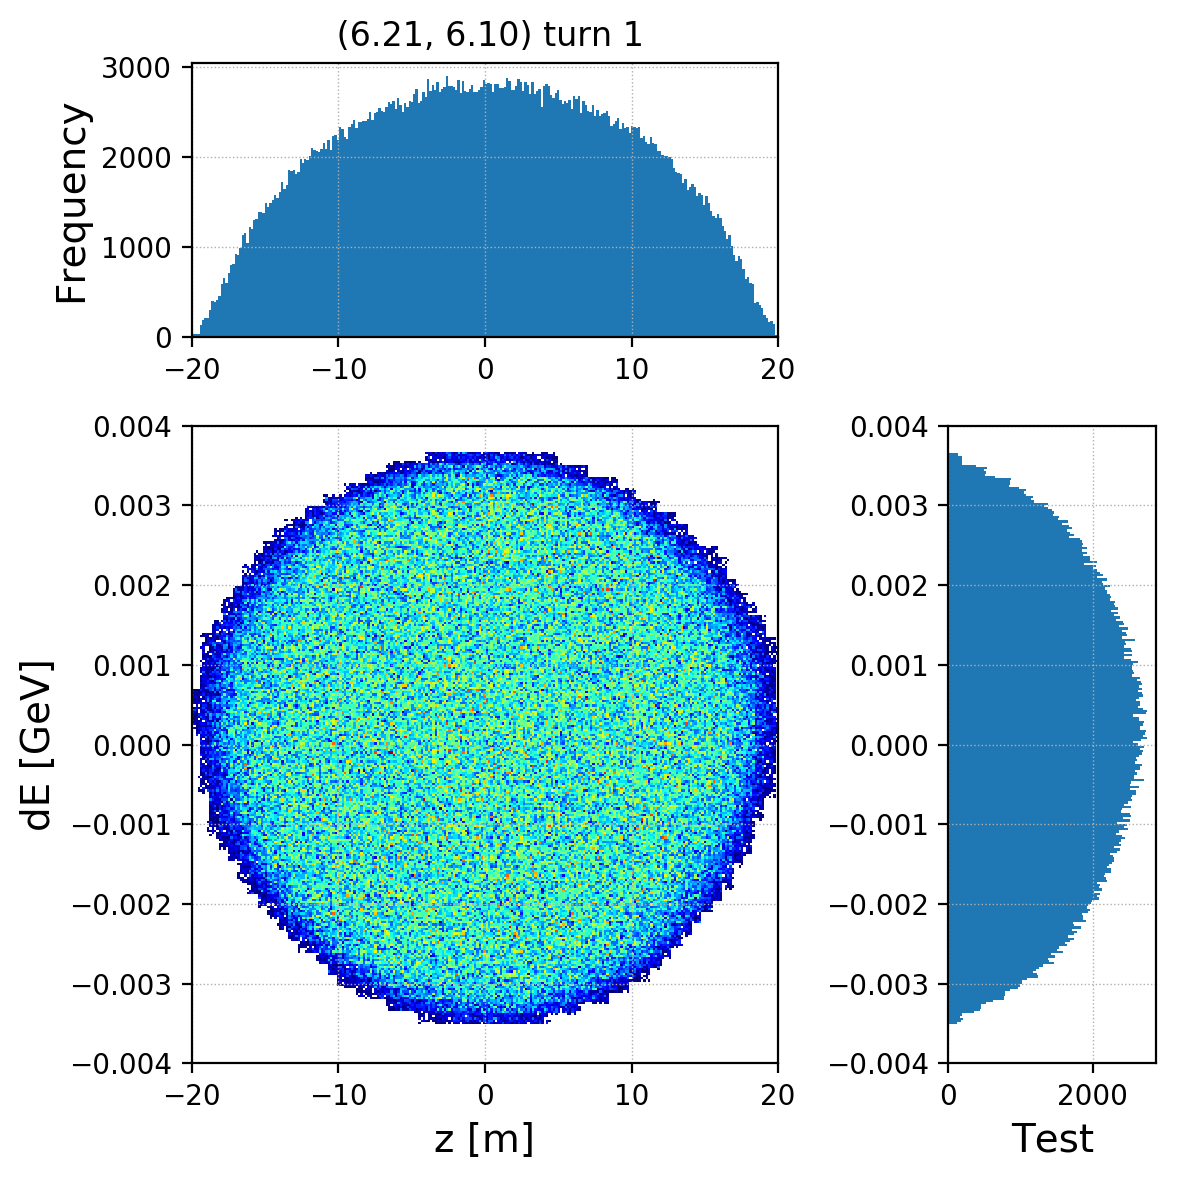

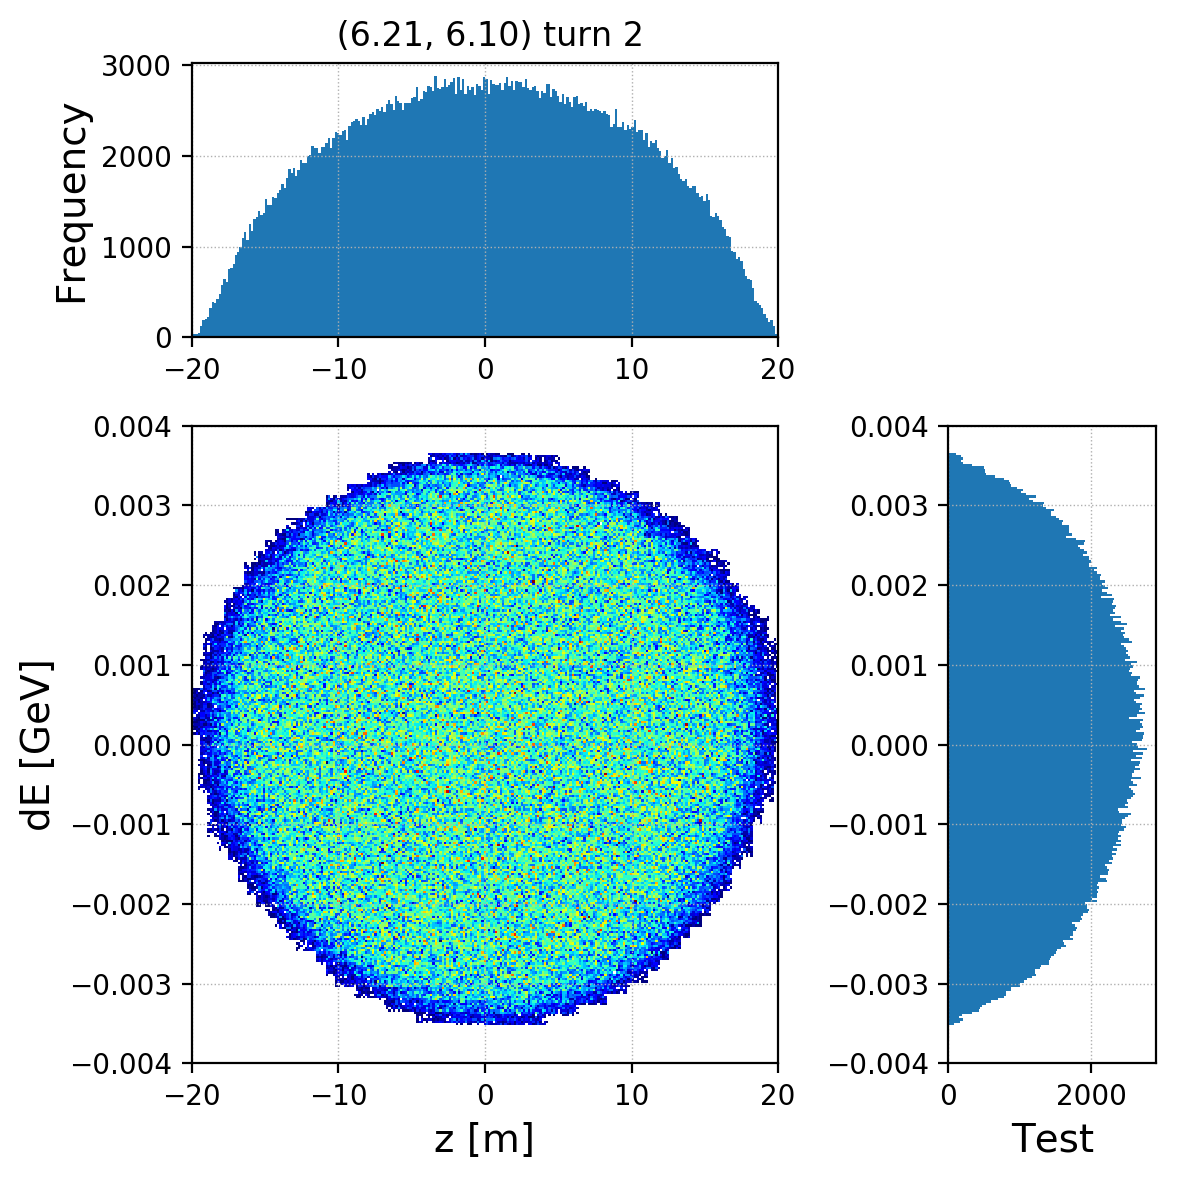

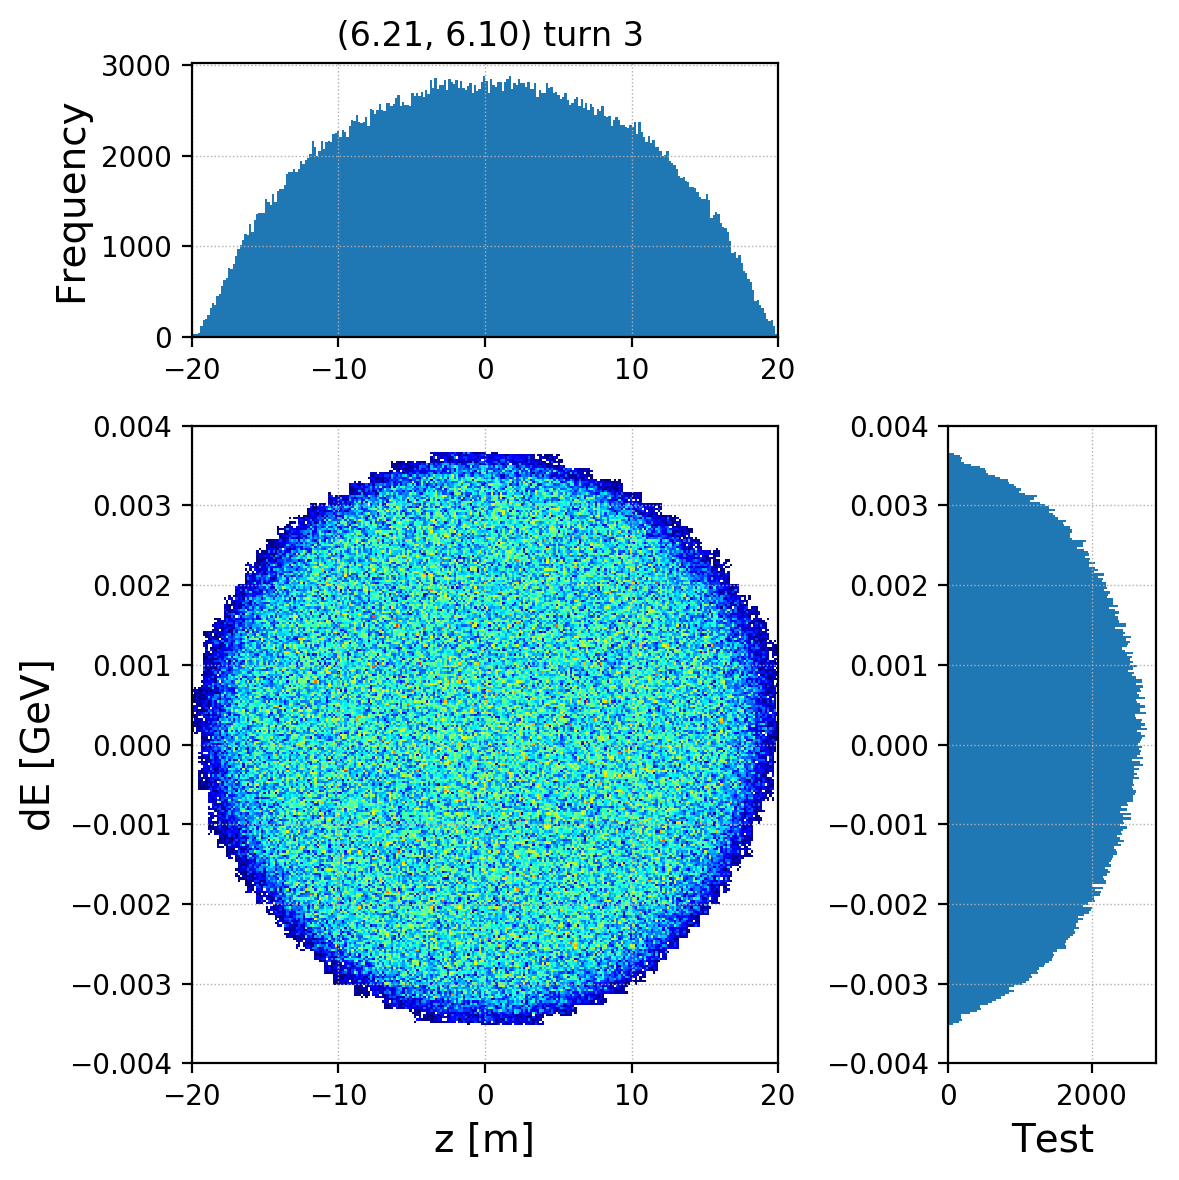

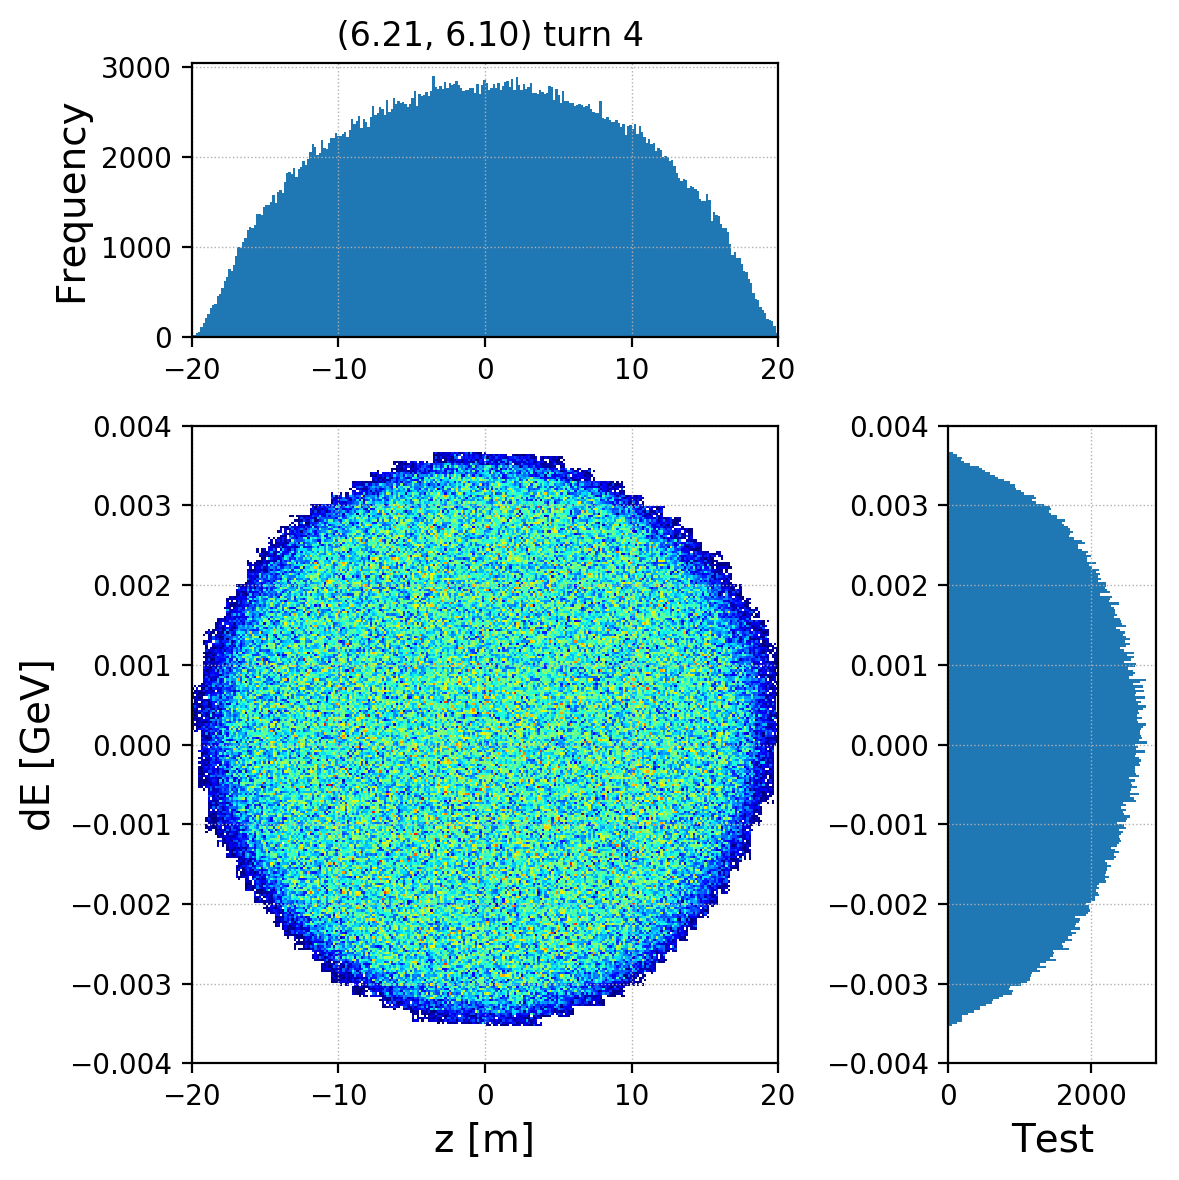

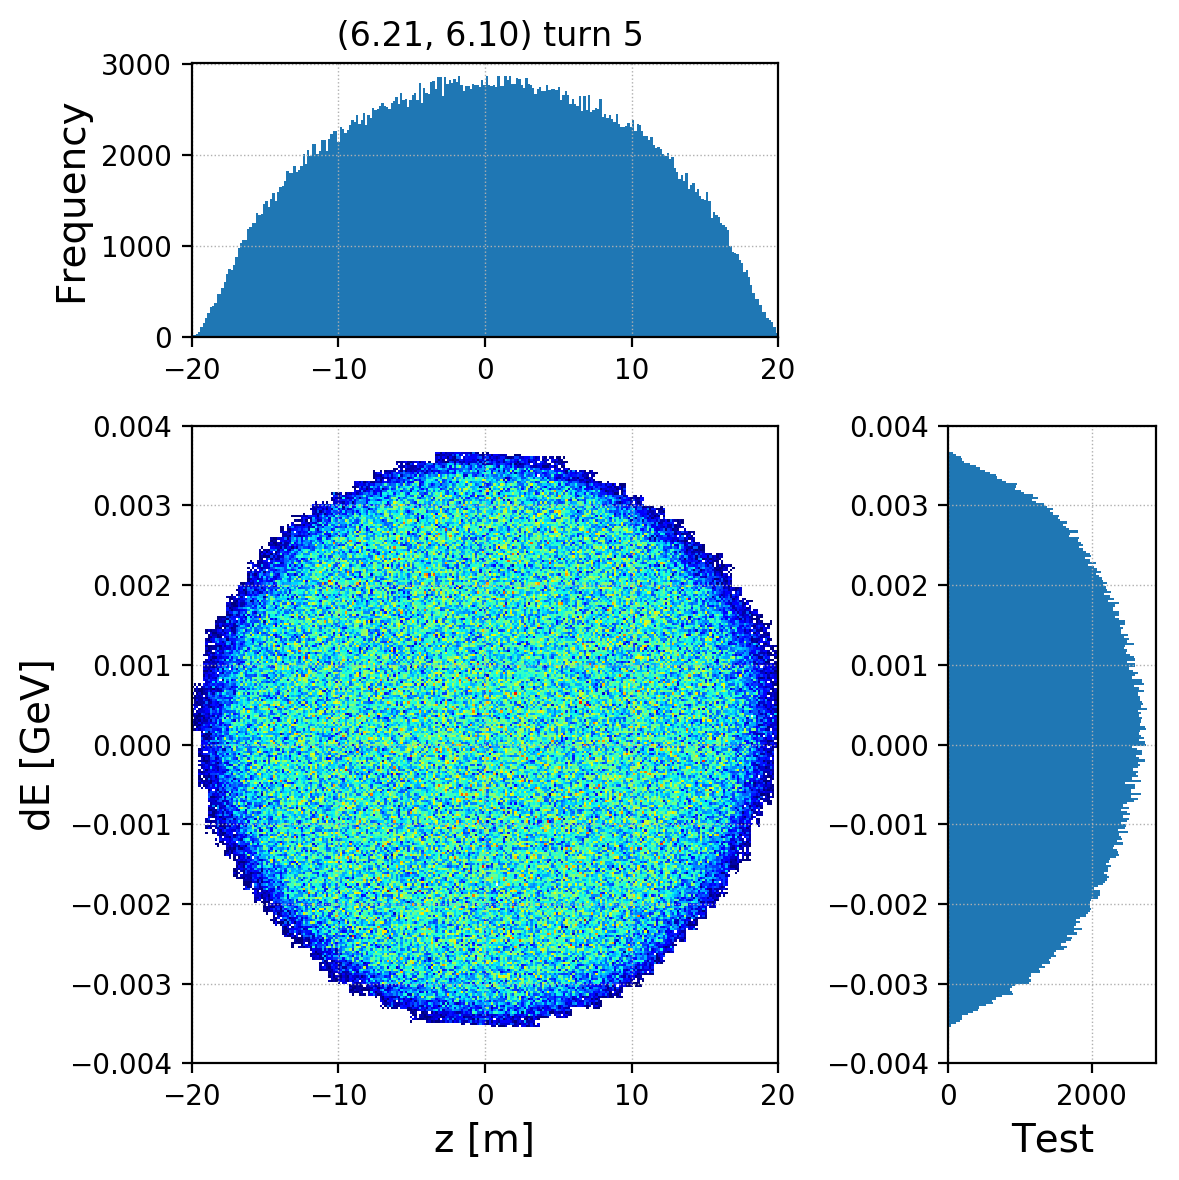

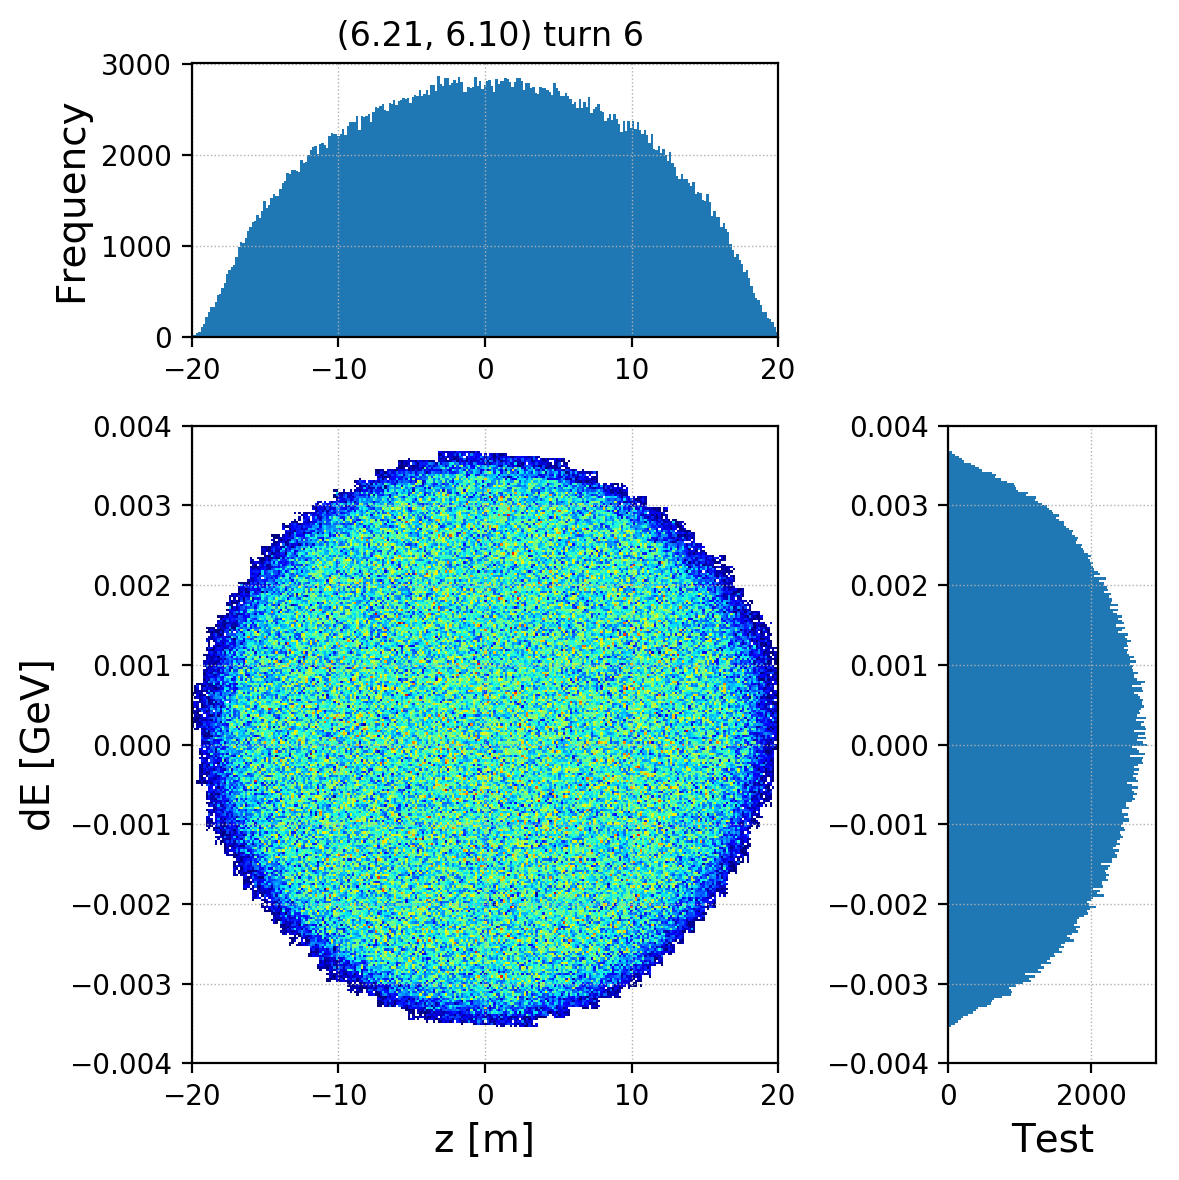

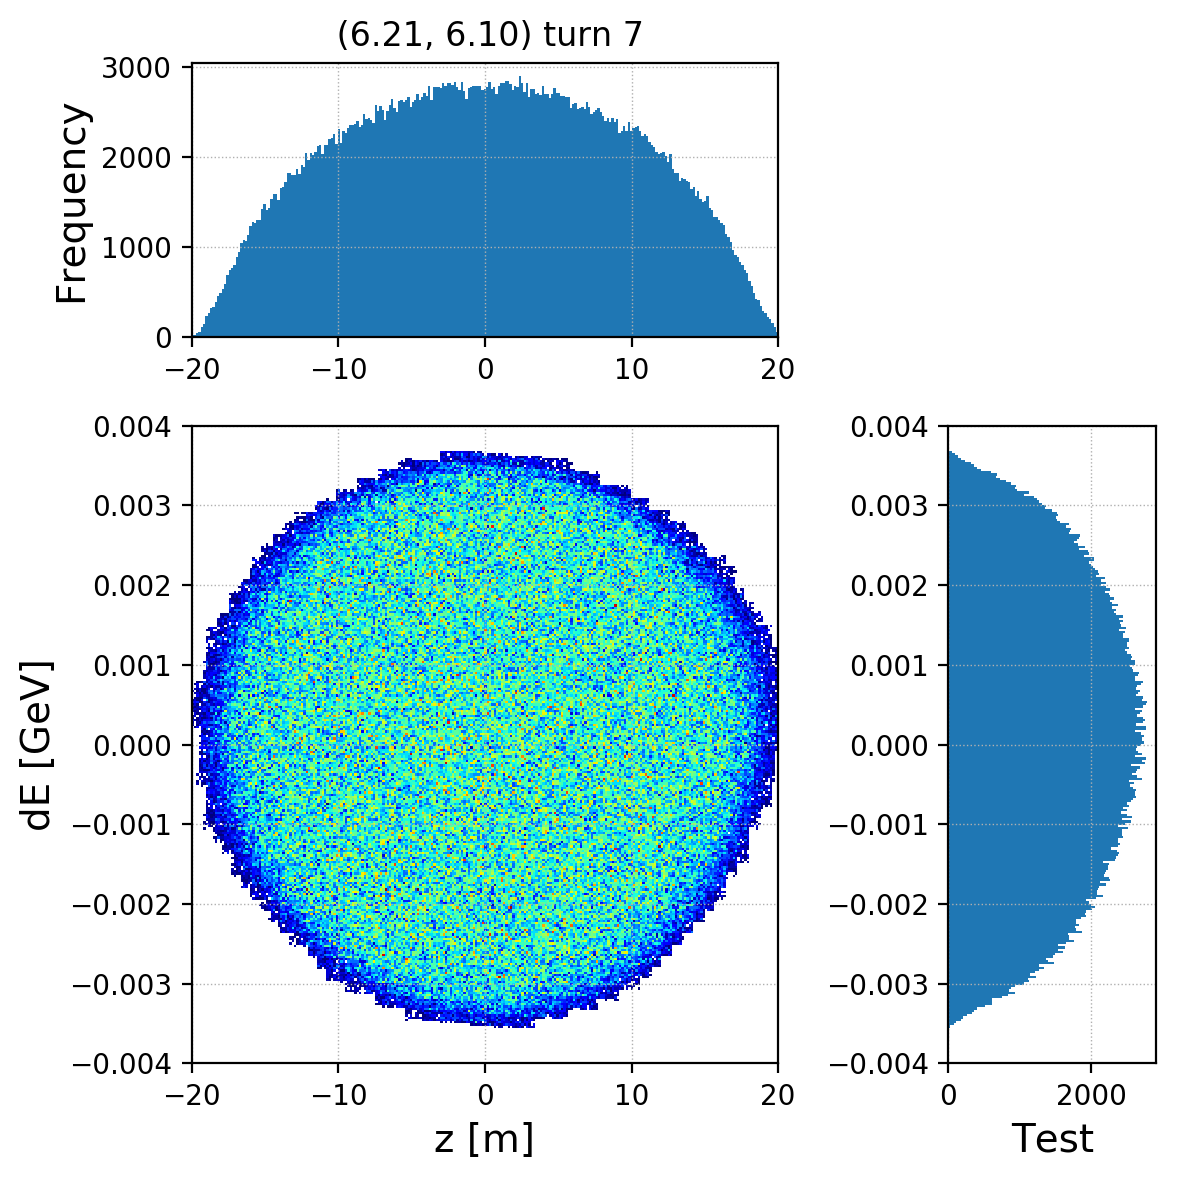

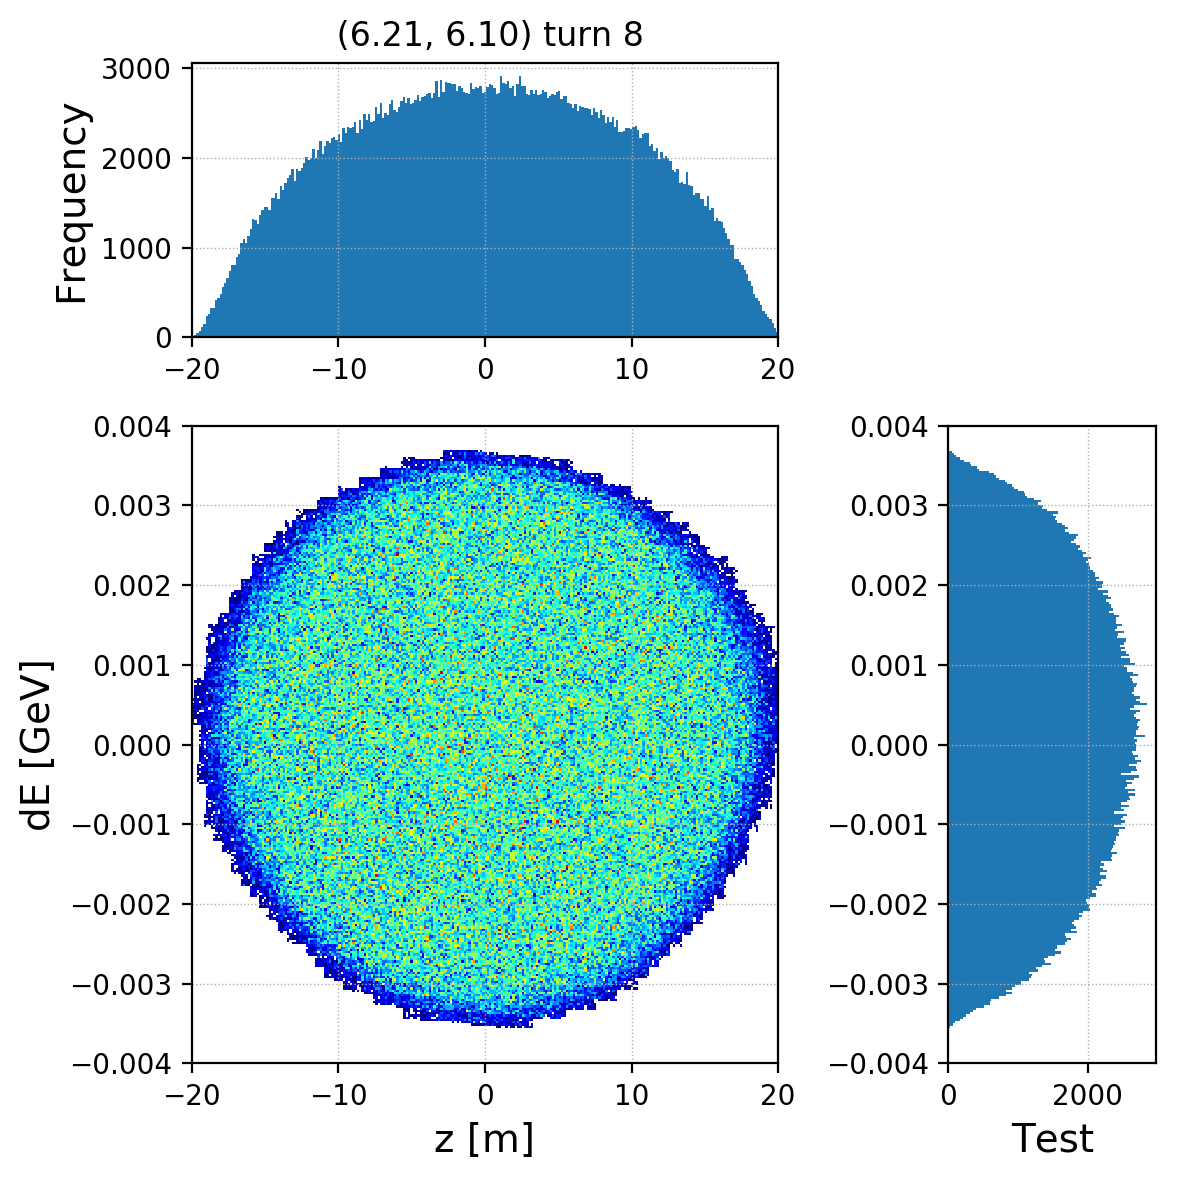

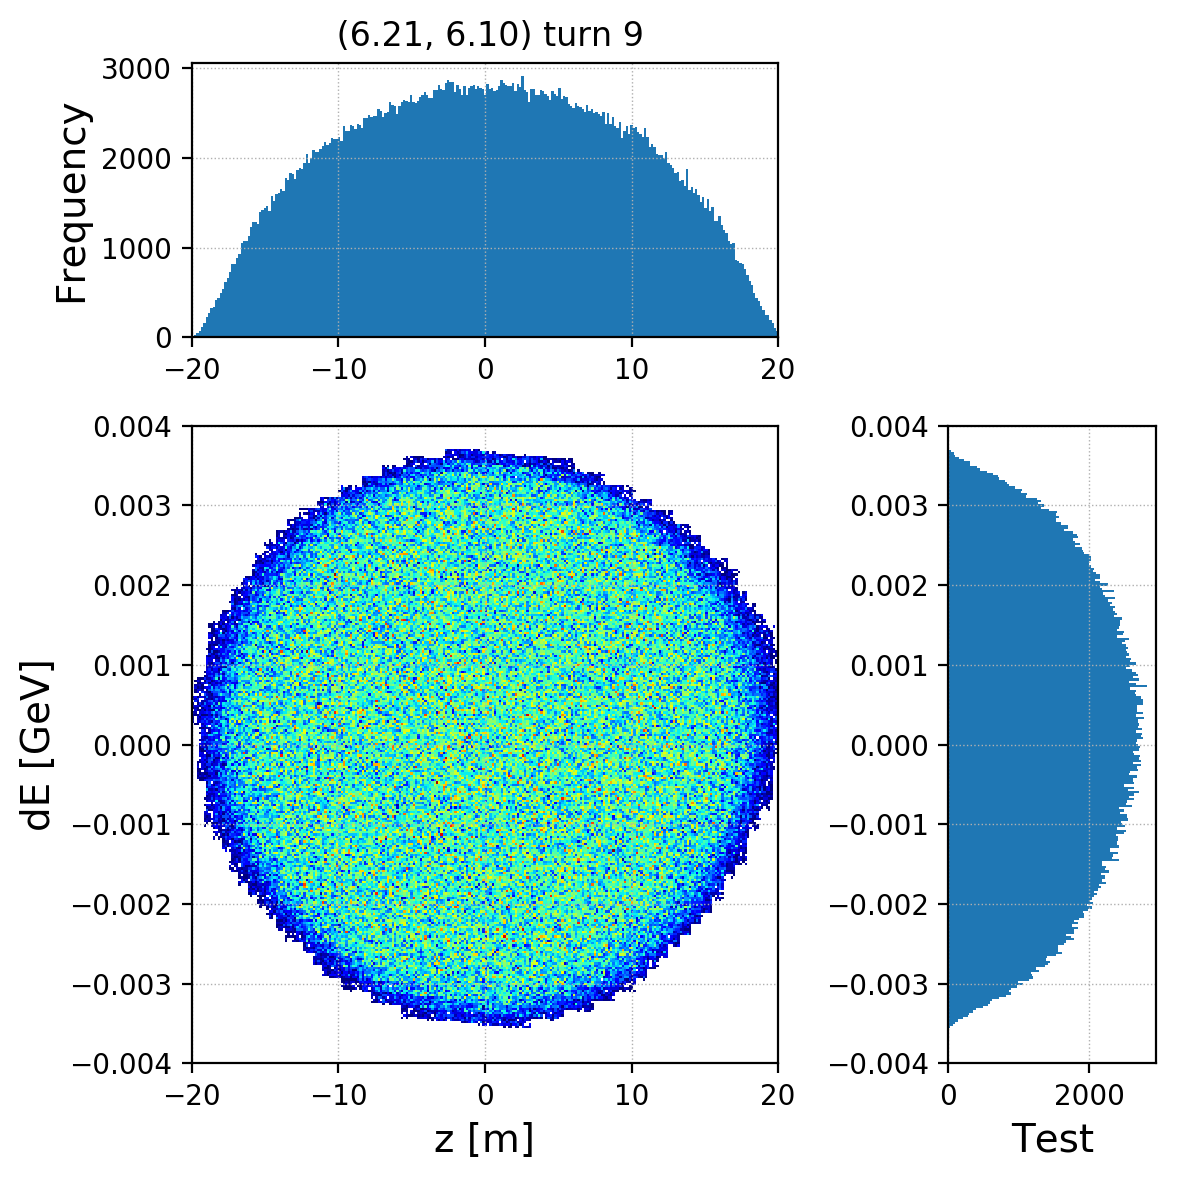

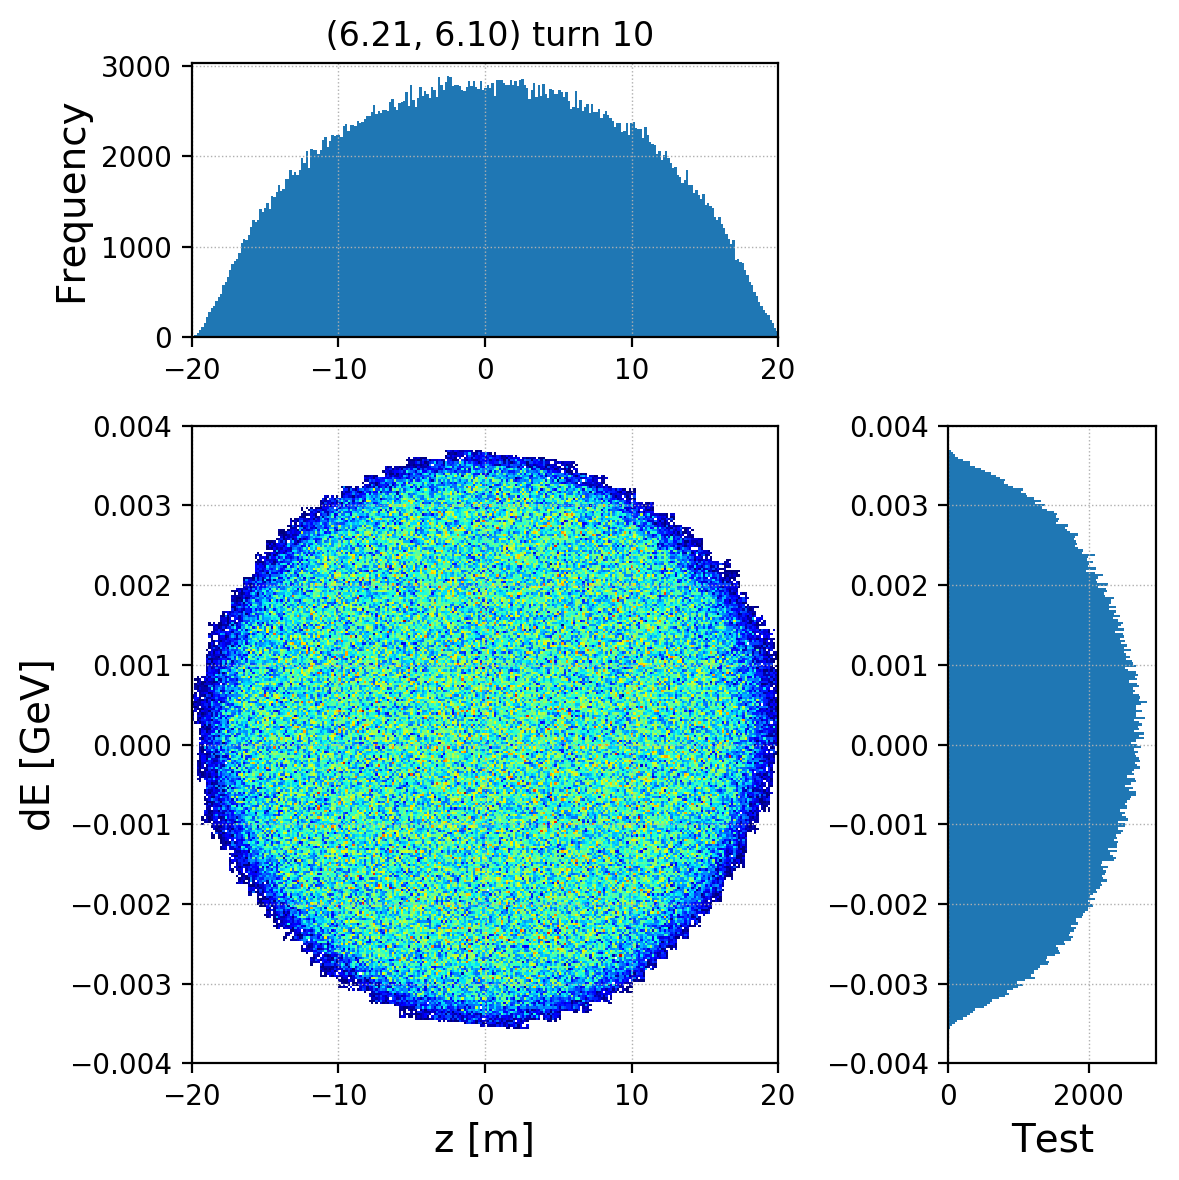

In [23]:
zdE_gifnames =[]

for i, file in enumerate(files):
    bin_size = 256
    
    tune_tit = '(6.21, 6.245)'    
    try: 
        #./Output_Files/Run2_BCMS_Turn_1.mat
        turn = int(file.split('/')[-1].split('_')[1].split('.')[0])
        case = str(file.split('/')[1].split('_')[4] + '_' + file.split('/')[1].split('_')[5])
        if str(file.split('/')[1].split('_')[4]) is 'V':
            tune_tit = '(6.21, 6.' + str(file.split('/')[1].split('_')[5]) + ')'
        else:
            tune_tit = '(6.' + str(file.split('/')[1].split('_')[5]) + '6.24)'
            
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\n\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', turn      
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    x  = particles.x * 1E3
    xp = particles.xp* 1E3
    y  = particles.y * 1E3
    yp = particles.yp* 1E3
    z  = particles.z
    dE = particles.dE
    
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots
    
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)
        
    title = str( main_label + ' ' + tune_tit + ' turn ' + str(turn)  ) 
    
    # First subplot
 
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title, fontsize=12)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)   
    
    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('z [m]')
    plt.ylabel('dE [GeV]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)
    plt.ylim(-0.004, 0.004)
    
    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.ylim(-0.004, 0.004)
    
    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)
    
    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)
    
    #ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    savename = str(folder + '/zdE_Phase_Space_' + case + '_turn_' + str(turn) + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)
    #plt.close(f)

In [ ]:
plt.close('all')
source_dir =  './MD4224/'
folder = './MD4224'

files2 = glob.glob(source_dir + '*.mat')
files2

In [ ]:
master_bins = 512
max_1d_hist = 10

min_tune = 5.85
max_tune = 6.25
q_fine = np.arange(5.5, 6.51, 0.01)


first_turn = True

for file in sorted(files2, reverse=False):
    
    tune_tit = '(6.21, 6.10)'
    
    try: 
        #./MD4224/0_Run2_BCMS_Turn_1.mat
        turn = int(file.split('_')[4][0])
        case = str(file.split('/')[2].split('_')[1] + '_' + file.split('/')[2].split('_')[2])
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\n\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
    
    # Load data 
    #------------------------------------------------------------------------------
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    #x  = particles.x
    #xp = particles.xp
    #y  = particles.y
    #yp = particles.yp
    #z  = particles.z
    #dE = particles.dE
    qx = particles.ParticlePhaseAttributes[2,:]
    qy = particles.ParticlePhaseAttributes[3,:]
    qx[np.where(qx>0.5)] -= 1
    qy[np.where((qy>0.6) & (qx<0.25))] -= 1 
     
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( case + ' ' + tune_tit + ' Turn = ' + str(turn) )    
    
    fig = plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)
    r = resonance_lines((min_tune, max_tune),(min_tune, max_tune),(1,2,3,4),10)
 
    # Calculate RMS Qx and Qy
    #------------------------------------------------------------------------------
    Q_x_rms = np.sqrt(moment(6+qx,2))
    Q_y_rms = np.sqrt(moment(6+qy,2))
    Q_x_min = np.min(6+qx)
    Q_x_max = np.max(6+qx)
    Q_y_min = np.min(6+qy)
    Q_y_max = np.max(6+qy)
    Delta_q_x = Q_x_max - Q_x_min
    Delta_q_y = Q_y_max - Q_y_min    
    Delta_q_x_4sig = 4 * Q_x_rms
    Delta_q_y_4sig = 4 * Q_y_rms
    Delta_q_x_6sig = 6 * Q_x_rms
    Delta_q_y_6sig = 6 * Q_y_rms
    
    # TEXT BOX (top right)
    #------------------------------------------------------------------------------
    #ax4 = fig.add_subplot(gs[0, 2:3])
    ax4txt = str(
                #'q_x_min = ' + str(round_sig(Q_x_min)) + '\n' +
                #'q_x_max = ' + str(round_sig(Q_x_max)) + '\n' +
                #'q_y_min = ' + str(round_sig(Q_y_min)) + '\n' +
                #' Turn = ' + str(turn) + '\n' +
                '<q_x> = ' + str(round_sig(np.mean(6+qx),3)) + '\n' +
                '<q_y> = ' + str(round_sig(np.mean(6+qy),3)) + '\n' + '\n' +
                'q_x_RMS = ' + str(round_sig(Q_x_rms)) + '\n' +
                'q_y_RMS = ' +str(round_sig(Q_y_rms)) + '\n'  + '\n' +  
                'Dq_x (4*RMS) = ' + str(round_sig(Delta_q_x_4sig)) + '\n' +
                'Dq_y (4*RMS) = ' + str(round_sig(Delta_q_y_4sig)) + '\n' + '\n' +
                'Dq_x (6*RMS) = ' + str(round_sig(Delta_q_x_6sig)) + '\n' +
                'Dq_y (6*RMS) = ' + str(round_sig(Delta_q_y_6sig)) + '\n'
                )
    #ax4.text(0.001, 0.001, ax4txt, fontsize=10)
    #ax4.set_yticklabels([])
    #ax4.set_xticklabels([])
    
    # FIRST SUBPLOT - x histogram
    #------------------------------------------------------------------------------
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax1.set_title(title)    
    n_x, bins_x, patches_x = ax1.hist(6+qx, bins=master_bins, range=(r.Qx_min, r.Qx_max), density=True) #, norm=mcolors.PowerNorm(gamma))
    bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins

    if first_turn:
        if np.max(n_x) > max_1d_hist :
            max_1d_hist = round(np.max(n_x),2) + 2
            print '\n\t max_1d_hist set to ', max_1d_hist
            first_turn = False
            
    # fit Gaussian to histogram
    try:    
        amp_min_x = 0.99 * np.max(n_x)
        amp_max_x = 1.2 * np.max(n_x)
        mean_min_x = 0.9 * bins_x[np.argmax(n_x)]
        mean_max_x = 1.1 * bins_x[np.argmax(n_x)]
        sig_min_x = 0.5 * Q_x_rms
        sig_max_x = 1.5 * Q_x_rms
        popt, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
        #ax1.plot(q_fine, gaussian(q_fine, popt[0], popt[1], popt[2]), 'k--', lw=1, label='Gaussian Fit')
        #ax1.plot(q_fine, gaussian(q_fine, popt[0], popt[1], Q_x_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
        #ax1.legend(loc=2)
    except RuntimeError:
        print '\n\t RuntimeError ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' q_x Gaussian fit not found'
        
    # ~ ax1.set_ylabel('Frequency')
    ax1.set_ylabel('Density [arb.]')
    ax1.grid(which='both', ls=':', lw=0.5)
    ax1.set_ylim(0, max_1d_hist)
    ax1.set_xlim(min_tune, max_tune)
    ax1.set_xticklabels([])
    
    # SECOND SUBPLOT - y histogram
    #------------------------------------------------------------------------------
    ax3 = fig.add_subplot(gs[1:3, 2])
    n_y, bins_y, patches_y = ax3.hist(6+qy, bins=master_bins, range=(r.Qy_min, r.Qy_max), orientation=u'horizontal', density=True) #, norm=mcolors.PowerNorm(gamma))
    bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

    # fit Gaussian to histogram
    try:
        amp_min_y = 0.99 * np.max(n_y)
        amp_max_y = 1.2 * np.max(n_y)
        mean_min_y = 0.9 * bins_y[np.argmax(n_y)]
        mean_max_y = 1.1 * bins_y[np.argmax(n_y)]
        sig_min_y = 0.5 * Q_y_rms
        sig_max_y = 1.5 * Q_y_rms
        popt, pcov = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
        #ax3.plot(gaussian(q_fine, popt[0], popt[1], popt[2]), q_fine, 'k--', lw=1, label='Gaussian Fit')
        #ax3.plot(gaussian(q_fine, popt[0], popt[1], Q_y_rms), q_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
    except RuntimeError:
        print '\n\t RuntimeError ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' q_y Gaussian fit not found'
        
    # ~ ax3.set_xlabel('Frequency')    
    ax3.set_xlabel('Density [arb.]')    
    ax3.set_xlim(0, max_1d_hist)
    ax3.set_ylim(min_tune, max_tune)
    ax3.grid(which='both', ls=':', lw=0.5)
    ax3.set_yticklabels([])
    
    # MAIN PLOT: TUNE FOOTPRINT
    #------------------------------------------------------------------------------
    ax2 = fig.add_subplot(gs[1:3, 0:2])
    r.plot_resonance(fig)
    ax2.hist2d(6+qx, 6+qy, bins=master_bins, cmap=my_cmap, vmin=1, range=[[r.Qx_min, r.Qx_max], [r.Qy_min, r.Qy_max]]) #, norm=mcolors.PowerNorm(gamma))
    ax2.set_xlabel(r'Q$_x$')
    ax2.set_ylabel(r'Q$_y$')
    ax2.set_ylim(min_tune, max_tune)
    ax2.grid(which='both', ls=':', lw=0.5)
 
    plt.tight_layout()
    savename = str(folder + '/Tune_Footprint_' + case + '_turn_' + str(turn) + '_new.png' )
    #tune_gifs.append(savename)
    fig.savefig(savename, dpi=500)
    plt.close(fig)

In [ ]:
 gifnames =[]

for file in files:
    tune_tit = '(6.21, 6.245)'
    
    try: 
        #./Output_Files/Run2_BCMS_Turn_1.mat
        turn = int(file.split('_')[4][0])
        case = str(file.split('/')[2].split('_')[0] + '_' + file.split('/')[2].split('_')[1])
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', turn, ' with histograms'
        
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    x  = particles.x
    xp = particles.xp
    y  = particles.y
    yp = particles.yp
    z  = particles.z
    dE = particles.dE

    fontsize=15

    qx = particles.ParticlePhaseAttributes[2,:]
    qy = particles.ParticlePhaseAttributes[3,:]
    qx[np.where(qx>0.5)] -= 1
    qy[np.where((qy>0.6) & (qx<0.25))] -= 1

    resonances = resonance_lines((5.75, 6.25),(5.75, 6.25),(1,2,3,4),10)
    fontsize=17
    
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots
    
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)
    
    r = resonances
    
    title = str( main_label + ' ' + tune_tit + ' turn ' + str(turn)  )    
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(6+qx, bins=1000, range=(r.Qx_min, r.Qx_max)) #, norm=mcolors.PowerNorm(gamma))
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.title(title, fontsize=fontsize)
    
    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(6+qx, 6+qy, bins=1000, cmap=my_cmap, vmin=1, range=[[r.Qx_min, r.Qx_max], [r.Qy_min, r.Qy_max]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel(r'Q$_x$')
    plt.ylabel(r'Q$_y$')
    resonances.plot_resonance(f)
    
    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(6+qy, bins=1000, range=(r.Qy_min, r.Qy_max), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    
    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)
    
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    
    ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    savename = str(folder + '/Tune_Footprint_' + case + '_turn_' + str(turn) + '.png' )
    gifnames.append(savename)
    f.savefig(savename, dpi=500)
    plt.close(f)

# XY Real Space

In [ ]:
xy_gifnames =[]
fontsize=12

for i, file in enumerate(files):
    bin_size = 256
    
    #folder = file.split('/')[0] + '/' + file.split('/')[1]
    #case = 'V'
    #tune_tit = '6.10'
    #tune_sav = '6p10' 
    
    try: 
        turn = int(file.split('mainbunch_')[-1][:-4])
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\t Plotting ', main_label, ' scan tune =', tune_tit, ' turn = ', str(turn), '  real space with histograms'
        
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    x  = particles.x * 1E3
    xp = particles.xp* 1E3
    y  = particles.y * 1E3
    yp = particles.yp* 1E3
    z  = particles.z * 1E9
    dE = particles.dE
    
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots
    
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)
        
    title = str( main_label + ' ' + tune_tit + ' turn ' + str(turn)  )    
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(x, bins=bin_size, range=(np.min(x), np.max(x))) #, norm=mcolors.PowerNorm(gamma))
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.title(title, fontsize=fontsize)
    plt.xlim(-20, 20)
    
    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(x, y, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(x), np.max(x)], [np.min(y), np.max(y)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    
    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(y, bins=bin_size, range=(np.min(y), np.max(y)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.ylim(-20, 20)
    
    #current_axis.axes.get_yaxis().set_visible(False)
    
    current_axis = plt.gca()
    
    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)
    
    #ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    savename = str(folder + '/Real_Space_' + case + '_' + tune_sav + '_turn_' + str(turn) + '.png' )
    xy_gifnames.append(savename)
    f.savefig(savename, dpi=500)
    plt.close(f)

# x xp phase space

In [ ]:
xxp_gifnames =[]

for i, file in enumerate(files):
    bin_size = 256
    
    #folder = file.split('/')[0] + '/' + file.split('/')[1]
    #case = 'V'
    #tune_tit = '6.10'
    #tune_sav = '6p10'  
    
    try: 
        turn = int(file.split('mainbunch_')[-1][:-4])
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', str(turn), '  real space with histograms'
        
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    x  = particles.x * 1E3
    xp = particles.xp* 1E3
    y  = particles.y * 1E3
    yp = particles.yp* 1E3
    z  = particles.z * 1E9
    dE = particles.dE
    
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots
    
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)
        
    title = str( main_label + ' ' + tune_tit + ' turn ' + str(turn)  ) 
    
    # First subplot
 
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(x, bins=bin_size, range=(np.min(x), np.max(x))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title, fontsize=fontsize)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)   
    
    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(x, xp, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(x), np.max(x)], [np.min(xp), np.max(xp)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('x [mm]')
    plt.ylabel('xp [mrad]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)
    plt.ylim(-1, 1)
    
    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(xp, bins=bin_size, range=(np.min(xp), np.max(xp)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.ylim(-1, 1)
    
    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)
    
    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)
    
    #ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    savename = str(folder + '/X_Phase_Space_' + case + '_' + tune_sav + '_turn_' + str(turn) + '.png' )
    xxp_gifnames.append(savename)
    f.savefig(savename, dpi=500)
    #plt.close(f)

# y yp phase space

In [ ]:
yyp_gifnames =[]

for i, file in enumerate(files):
    bin_size = 256
    
    #folder = file.split('/')[0] + '/' + file.split('/')[1]
    #case = 'V'
    #tune_tit = '6.10'
    #tune_sav = '6p10'  
    
    try: 
        turn = int(file.split('mainbunch_')[-1][:-4])
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', str(turn), '  real space with histograms'
        
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    x  = particles.x * 1E3
    xp = particles.xp* 1E3
    y  = particles.y * 1E3
    yp = particles.yp* 1E3
    z  = particles.z * 1E9
    dE = particles.dE
    
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots
    
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)
        
    title = str( main_label + ' ' + tune_tit + ' turn ' + str(turn)  ) 
    
    # First subplot
 
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(y, bins=bin_size, range=(np.min(y), np.max(y))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title, fontsize=fontsize)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)   
    
    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(y, yp, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(y), np.max(y)], [np.min(yp), np.max(yp)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('y [mm]')
    plt.ylabel('yp [mrad]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)
    plt.ylim(-1, 1)
    
    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(yp, bins=bin_size, range=(np.min(yp), np.max(yp)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.ylim(-1, 1)
    
    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)
    
    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)
    
    #ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    savename = str(folder + '/Y_Phase_Space_' + case + '_' + tune_sav + '_turn_' + str(turn) + '_hist.png' )
    yyp_gifnames.append(savename)
    f.savefig(savename, dpi=500)
    #plt.close(f)

# Longitudinal Phase Space

In [ ]:
zdE_gifnames =[]

for i, file in enumerate(files):
    bin_size = 256
    
    #folder = file.split('/')[0] + '/' + file.split('/')[1]
    #case = 'V'
    #tune_tit = '6.10'
    #tune_sav = '6p10'  
    
    try: 
        turn = int(file.split('mainbunch_')[-1][:-4])
        #turn = '%04d'%turn
    except:
        turn = ''
        
    print '\t Plotting ', case, ' scan tune =', tune_tit, ' turn = ', str(turn), '  real space with histograms'
        
    particles = sio.loadmat(file, squeeze_me=True,  struct_as_record=False)['particles']
    x  = particles.x * 1E3
    xp = particles.xp* 1E3
    y  = particles.y * 1E3
    yp = particles.yp* 1E3
    z  = particles.z
    dE = particles.dE
    
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots
    
    
    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)
        
    title = str( main_label + ' ' + tune_tit + ' turn ' + str(turn)  ) 
    
    # First subplot
 
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title, fontsize=fontsize)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)   
    
    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('z [m]')
    plt.ylabel('dE [GeV]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-20, 20)
    plt.ylim(-0.004, 0.004)
    
    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.ylim(-0.004, 0.004)
    
    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)
    
    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)
    
    #ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    savename = str(folder + '/zdE_Phase_Space_' + case + '_' + tune_sav + '_turn_' + str(turn) + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)
    #plt.close(f)